Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)


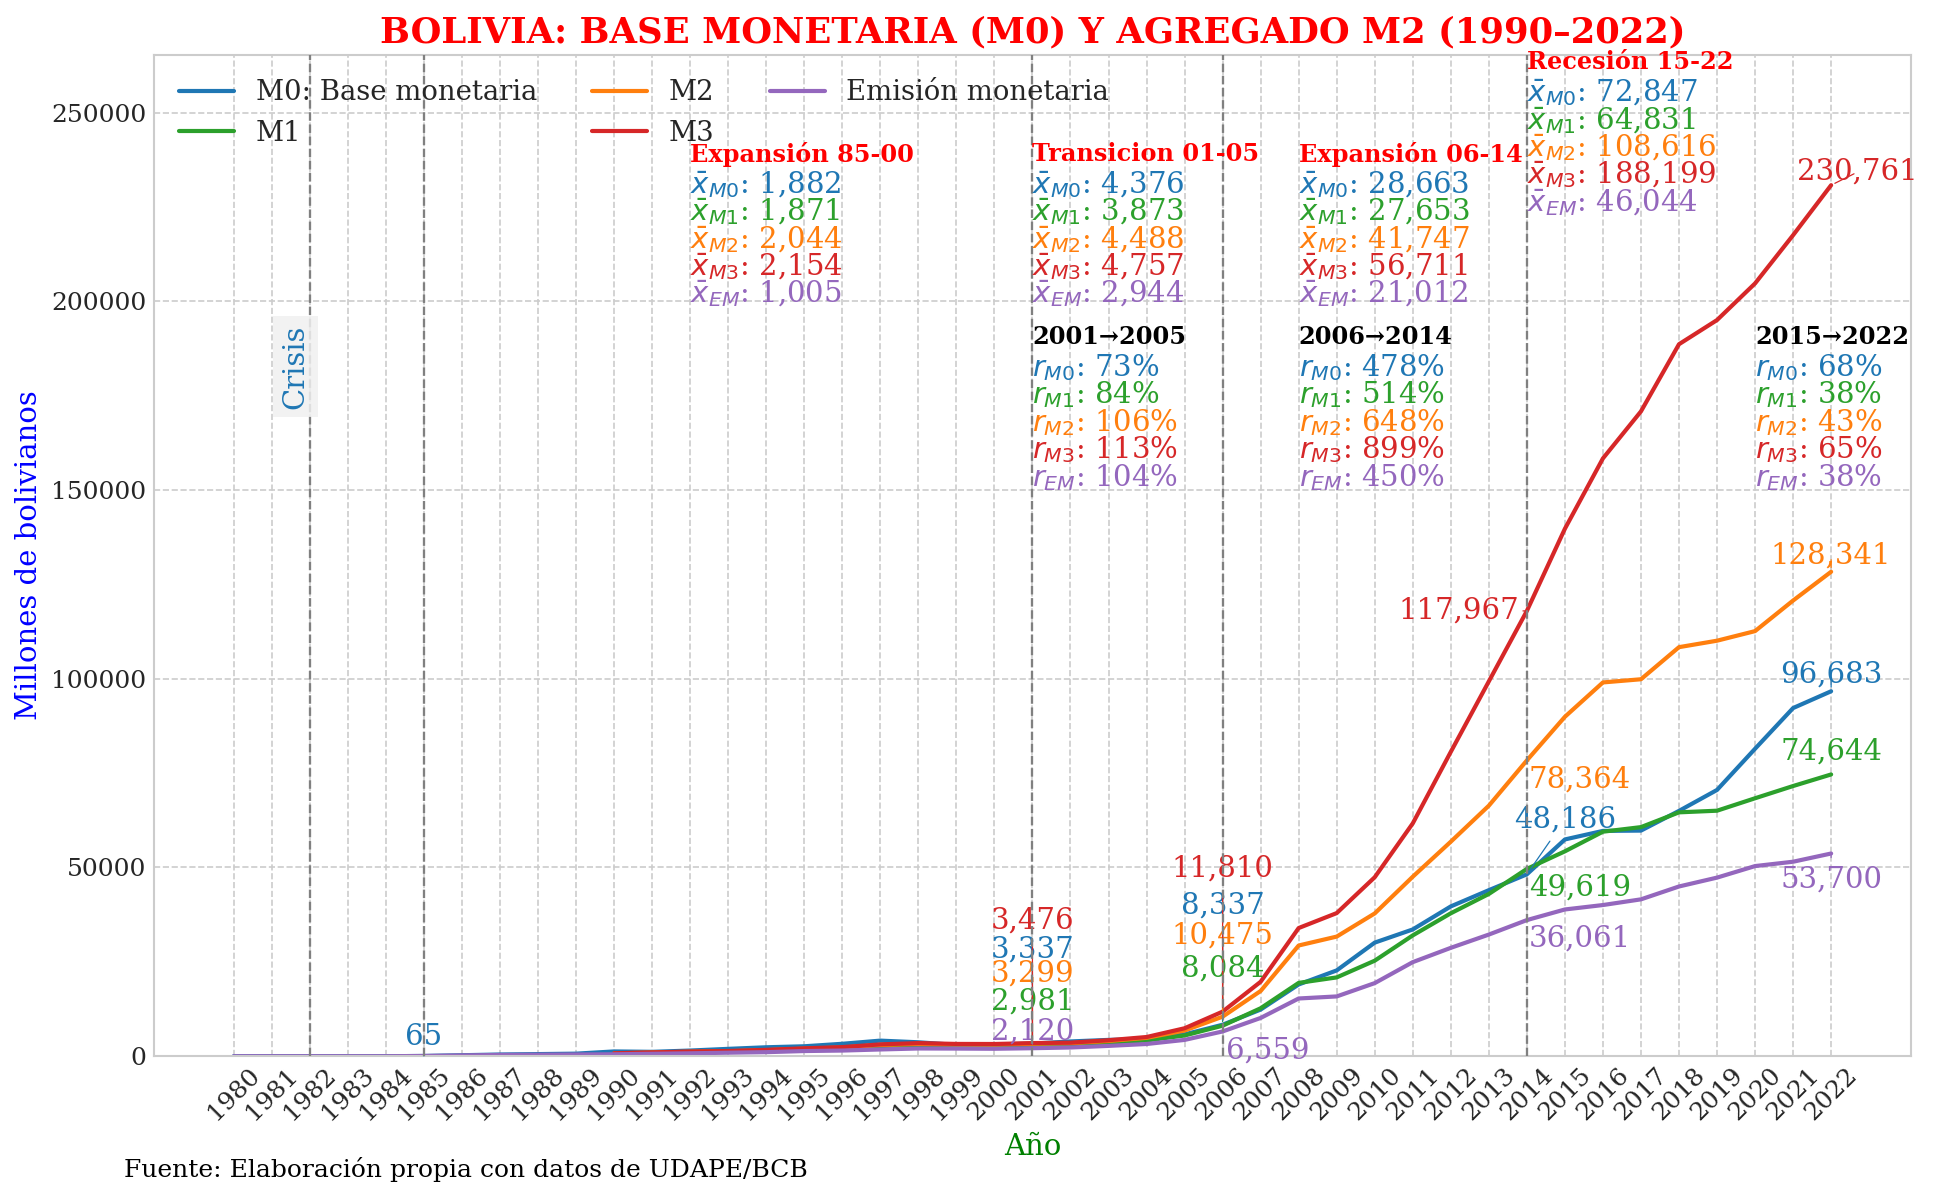

In [53]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones
# ─────────────────────────────────────────────────────────────────────
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from func_auxiliares.config import *
from func_auxiliares.graficos_utils import *
# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/monetaria"
os.makedirs(output_dir, exist_ok=True)
set_style()

# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
with sqlite3.connect(str(DB_PATH)) as conn:
    df = (pd.read_sql('SELECT año, m0,m1, m2,m3, emision_monetaria FROM agregados_monetarios', conn)
            .set_index('año')
            .sort_index())/ 1000 # miles → millones

# ─────────────────────────────────────────────────────────────────────
# Componentes y columnas
# ─────────────────────────────────────────────────────────────────────
componentes = [
    ("m0",  "M0: Base monetaria"),
    ("m1",  "M1"),
    ("m2",  "M2"),
    ("m3",  "M3"),
    ("emision_monetaria", "Emisión monetaria"),
]
cols_componentes = [col for col, _ in componentes]

abbr_map = {
    "m0": "M0", "m1": "M1", "m2": "M2",
    "m3": "M3", "emision_monetaria": "EM",
}

custom_colors = {
    "m0": "#1f77b4",         # azul
    "m1": "#2ca02c",         # verde
    "m2": "#ff7f0e",         # naranja
    "m3": "#d62728",         # rojo
    "emision_monetaria": "#9467bd",  # morado
}

# ─────────────────────────────────────────────────────────────────────
# Preparación (usa helpers de tu proyecto)
# ─────────────────────────────────────────────────────────────────────
# Ajustes de años a anotar y ciclos, reusando tu configuración global
annotate_years    = adjust_annot_years(df, annot_years)
CYCLES            = adjust_cycles(df, CYCLES)
cycle_stats       = {name: df.loc[period, cols_componentes].mean().to_dict()
                     for name, period in CYCLES.items()}
periodos          = adjust_periods(df, periodos_tasas)

# Offsets mínimos para apuntadores de valores (ajusta si se solapan)
annotation_offsets = {
    'm0': {1985: (0, 5000), 2001: (0, 25000),2006:(0,31500), 2014: (1, 14500), 2022: (0, 4500)},
    'm2': {1985: (0, 0), 2001: (0, 18500),2006:(0,21500), 2014: (1.4, -5000), 2022: (0, 4300)},
    'm1': {1985: (0, 5000), 2001: (0, 11500),2006:(0,15000), 2014: (1.4, -5000), 2022: (0, 6000)},
    'm3': {1985: (0, 0), 2001: (0, 32500),2006:(0,38000), 2014: (-1.8, 0), 2022: (0.7, 3500)},
    'emision_monetaria': {2001: (0, 4500),2006:(1.2,-5000), 2014: (1.4, -5000), 2022: (0, -7000)},
}

hitos_offset = {a: 0.8 for a in hitos_v}  


# Posiciones de las medias por ciclo (ajústalas si cambias CYCLES)
medias_offsets = {
    "Expansión 85-00":    (1992, 1),
    "Transicion 01-05":   (2001, 1),
    "Expansión 06-14":    (2008, 1),
    "Recesión 15-22":     (2014, 1.1),
}

# Tasas anotadas por periodo (si no deseas tasas, comenta el bloque de add_period...)
tasas_offsets = {

    "2001-2005": (2001, 0.8),
    "2006-2014": (2008, 0.8),
    "2015-2022": (2020, 0.8),
}

# ─────────────────────────────────────────────────────────────────────
# Gráfica
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    componentes,
    custom_colors,
    "BOLIVIA: BASE MONETARIA (M0) Y AGREGADO M2 (1990–2022)",
    "Año",
    "Millones de bolivianos",
    source_text="Fuente: Elaboración propia con datos de UDAPE/BCB"
)

# Hitos verticales
add_hitos(ax, df.index, hitos_v, hitos_offset)

# Medias por ciclo (líneas y etiquetas por ciclo)
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr_map, custom_colors,
    line_spacing
)

# Anotar valores en años clave
add_year_value_annotations(
    ax, df, annotate_years,
    cols_componentes, annotation_offsets,
    custom_colors, arrow_lw=0.6
)

# Tasas de crecimiento por periodos (opcional; usa periodos_tasas de config)
add_period_growth_annotations_multi(
    ax, df, periodos,
    cols_componentes, tasas_offsets,
    custom_colors, abbr_map
)

# Límite inferior en cero y margen superior
ax.set_ylim(0, df[cols_componentes].max().max() * 1.15)

# Guardado y despliegue
plt.savefig(os.path.join(output_dir, "m0_m2.png"), dpi=300, bbox_inches="tight")
plt.show()
